In [1]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
# from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import scipy

<IPython.core.display.Javascript object>


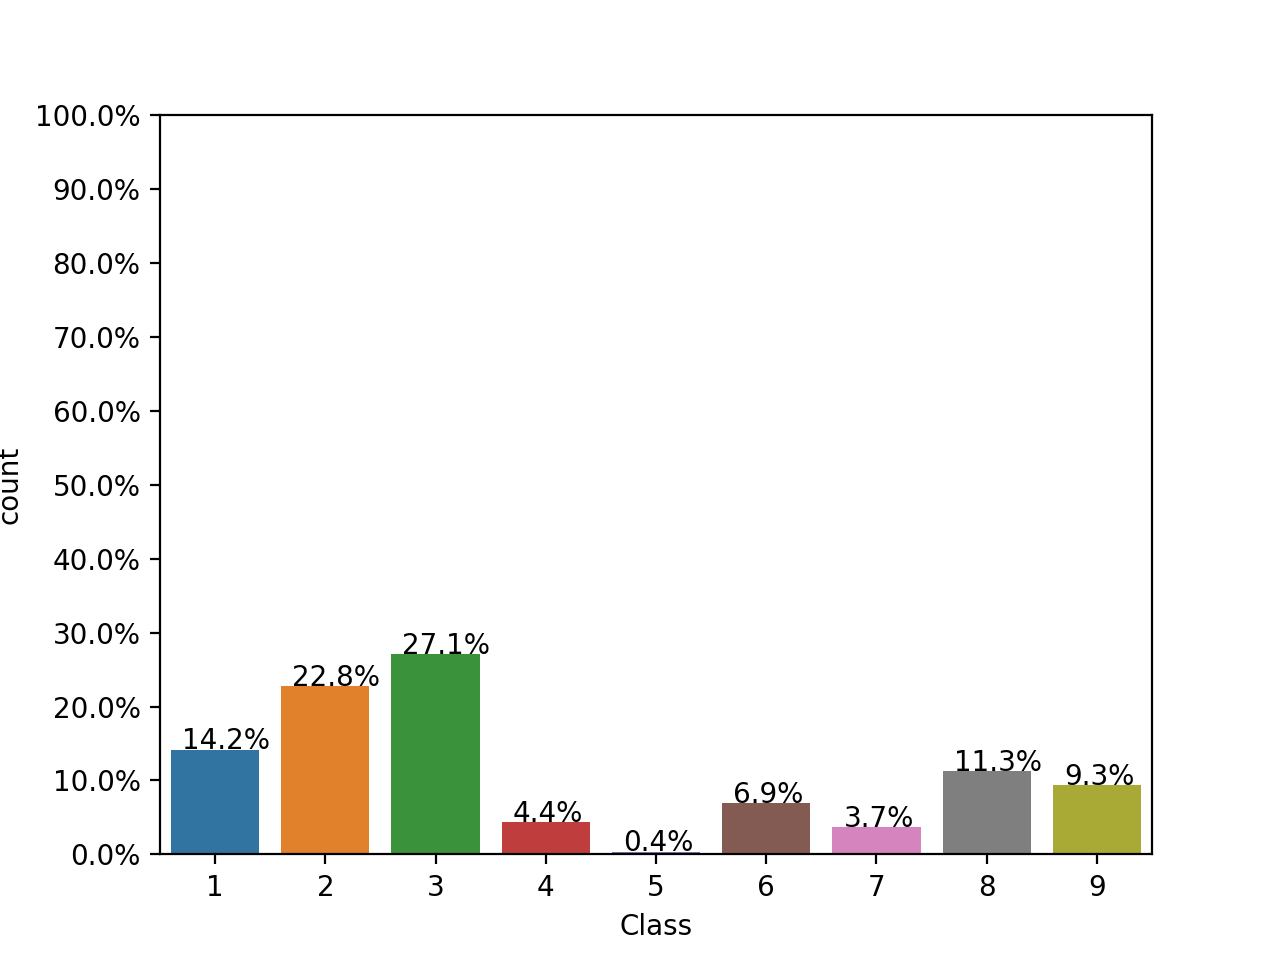

In [2]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [3]:
byte_features_with_size=pd.read_csv("result_with_size.csv")
byte_features_with_size['ID']  = byte_features_with_size['ID'].str.split('.').str[0]
byte_features_with_size = byte_features_with_size.drop(byte_features_with_size.columns[0], axis=1)
byte_features_with_size.head()

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,gP2lDJxn9mFV5U0dujbs,4447,179,140,231,284,149,165,145,201,...,151.0,140.0,156.0,156.0,152.0,147.0,240.0,17564.0,0.226562,4
1,8MSg6ycte4mZsOQL9bVN,7048,4523,94,73,122,69,38,45,418,...,20.0,3392.0,35.0,69.0,482.0,4972.0,2102.0,84.0,1.911621,2
2,gLlmqtyshpVY7D0H5TkR,68573,101891,25596,25085,4165,2513,2783,2374,4611,...,1713.0,1275.0,1432.0,2218.0,2015.0,2308.0,26548.0,12768.0,4.167210,2
3,DaZMVyFxkg6QBRnHILl5,8997,574,532,563,515,542,522,524,517,...,428.0,439.0,494.0,472.0,442.0,439.0,604.0,57560.0,0.665527,6
4,DNtJKyn0WV7PeS3q8FvO,11198,5567,3347,3279,3364,3252,3195,3279,3153,...,3149.0,3167.0,3187.0,3276.0,3223.0,3204.0,7132.0,1490076.0,8.099609,3


In [4]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(byte_features_with_size)

In [5]:
result.head(2)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,gP2lDJxn9mFV5U0dujbs,0.001942,0.000381,0.000078,0.000125,0.000174,0.000084,0.000093,0.000405,0.000464,...,0.000660,0.000631,0.000687,0.001794,0.000714,0.000765,0.000327,0.002803,0.005341,4
1,8MSg6ycte4mZsOQL9bVN,0.003077,0.009624,0.000052,0.000039,0.000075,0.000039,0.000021,0.000126,0.000965,...,0.000087,0.015292,0.000154,0.000794,0.002263,0.025858,0.002866,0.000013,0.080877,2


In [6]:
data_y = result['Class']

In [8]:
#multivariate analysis on byte files
#this is with perplexity 50
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

Using matplotlib backend: agg


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

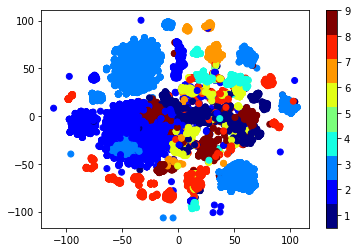

In [10]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

In [9]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [10]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 3192
Number of data points in test data: 998
Number of data points in cross validation data: 799


## Train,CV, Test distribution and def confusion matrix

In [11]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


AttributeError: 'Series' object has no attribute 'sortlevel'

In [14]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

## Random Model

Log loss on Cross Validation Data using Random Model 2.489806229760278
Log loss on Test Data using Random Model 2.500377385936383
Number of misclassified points  88.40846366145354
-------------------------------------------------- Confusion matrix --------------------------------------------------


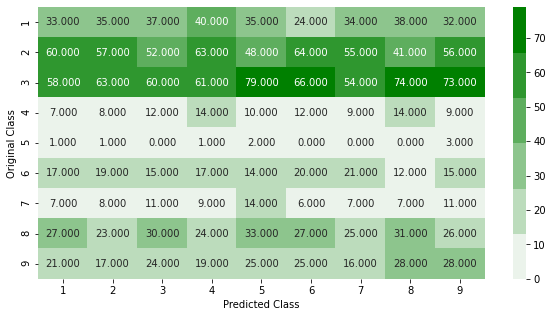

-------------------------------------------------- Precision matrix --------------------------------------------------


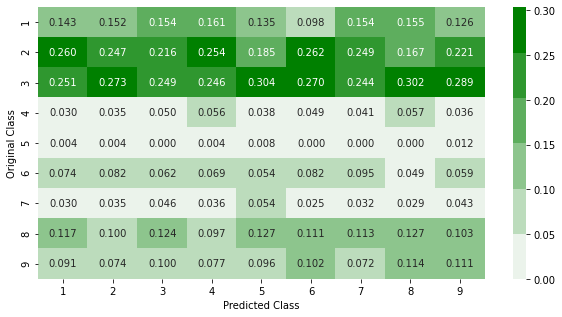

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


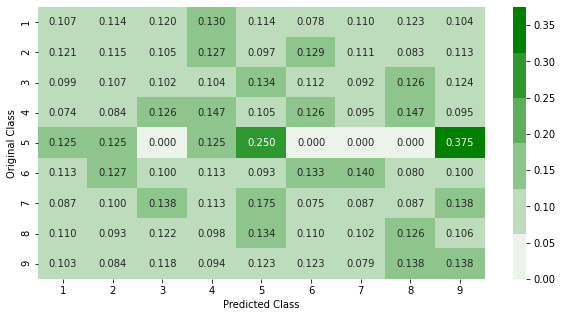

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## K-NN Model

log_loss for k =  1 is 0.24507258277708757
log_loss for k =  3 is 0.23544471726168115
log_loss for k =  5 is 0.25382597223974984
log_loss for k =  7 is 0.27131931708071494
log_loss for k =  9 is 0.28372788345715094
log_loss for k =  11 is 0.29772052014881584
log_loss for k =  13 is 0.3090534415852273


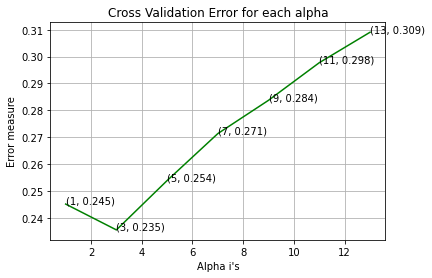

For values of best alpha =  3 The train log loss is: 0.11399223049037133
For values of best alpha =  3 The cross validation log loss is: 0.23544471726168115
For values of best alpha =  3 The test log loss is: 0.23215083991695754
Number of misclassified points  5.243790248390065
-------------------------------------------------- Confusion matrix --------------------------------------------------


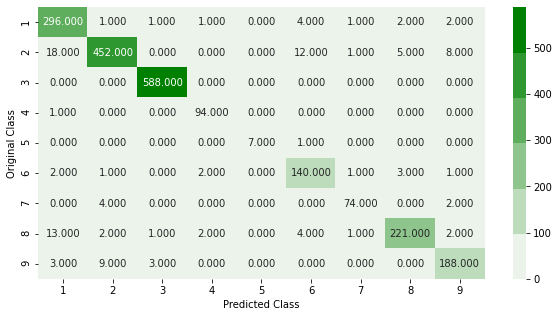

-------------------------------------------------- Precision matrix --------------------------------------------------


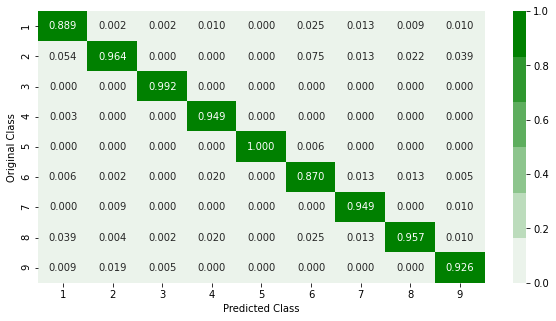

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


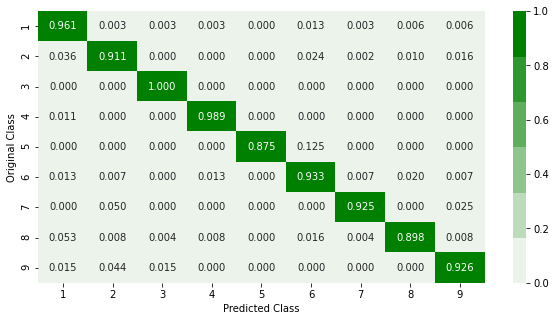

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
  
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Logistic Regression

log_loss for c =  1e-05 is 1.1586883746851864
log_loss for c =  0.0001 is 1.1586592239102185
log_loss for c =  0.001 is 1.1553525489392629
log_loss for c =  0.01 is 1.128189945791105
log_loss for c =  0.1 is 1.026189249132178
log_loss for c =  1 is 0.9517654442526091
log_loss for c =  10 is 0.8795166882674578
log_loss for c =  100 is 0.8665598018243413
log_loss for c =  1000 is 0.8698115716908535


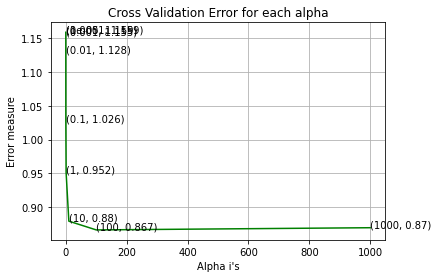

log loss for train data 0.8628403138934116
log loss for cv data 0.8665598018243413
log loss for test data 0.8689748012582645
Number of misclassified points  28.150873965041402
-------------------------------------------------- Confusion matrix --------------------------------------------------


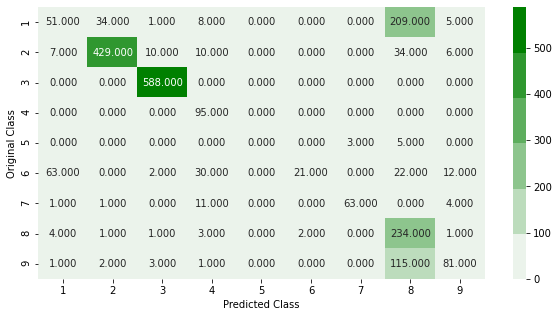

-------------------------------------------------- Precision matrix --------------------------------------------------


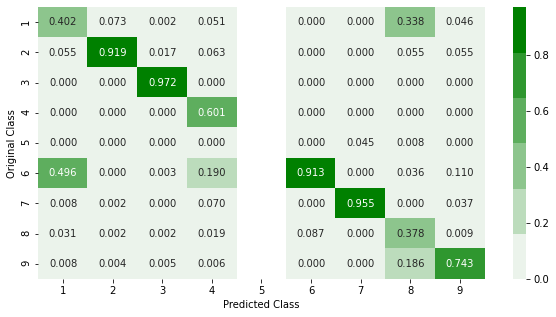

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


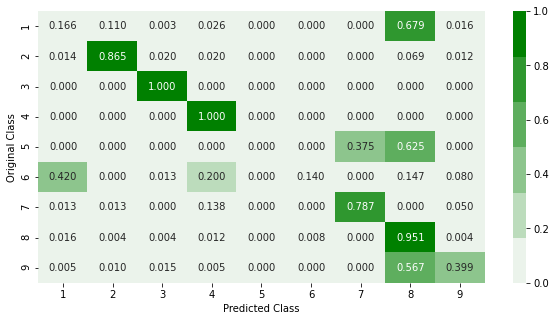

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## Random Forest

log_loss for c =  10 is 0.10700349859125545
log_loss for c =  50 is 0.09869639271906094
log_loss for c =  100 is 0.10002871971332762
log_loss for c =  500 is 0.09817594229778107
log_loss for c =  1000 is 0.09789501807618385
log_loss for c =  2000 is 0.09808131526279508
log_loss for c =  3000 is 0.0980814331009672


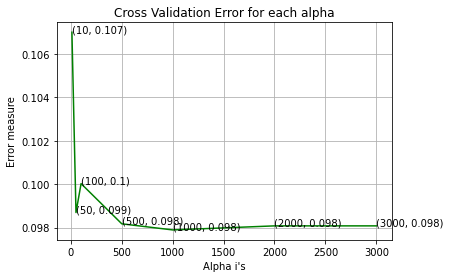

KeyboardInterrupt: ignored

In [18]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XG Boost

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

## XgBoost Classification with best hyper parameters using RandomSearch

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

In [ ]:
print (random_cfl1.best_params_)

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=1, max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

# ASM Starts...

In [14]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("asmoutputfile.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,18,66,15,43,83,0,17,48,29,1
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,18,29,48,82,12,0,14,0,20,1
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,13,42,10,67,14,0,11,0,9,1
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,6,8,14,7,2,0,8,0,6,1
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,12,9,18,29,5,0,11,0,11,1


In [15]:
asm_size_byte=pd.read_csv("asm_with_size.csv")
asm_size_byte.head()

,Unnamed: 0,ID,size,Class
0,0,01azqd4InC7m9JpocGv5,56.229886,9
1,1,01IsoiSMh5gxyDYTl4CB,13.999378,2
2,2,01jsnpXSAlgw6aPeDxrU,8.507785,9
3,3,01kcPWA9K2BOxQeS5Rju,0.078190,1
4,4,01SuzwMJEIXsK7A8dQbl,0.996723,8


In [16]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [17]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class','Unnamed: 0'], axis=1),on='ID', how='left')
result_asm.head()

(10868, 53)
(10868, 4)


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,66,15,43,83,0,17,48,29,1,0.078190
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,29,48,82,12,0,14,0,20,1,0.063400
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,42,10,67,14,0,11,0,9,1,0.041695
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,8,14,7,2,0,8,0,6,1,0.018757
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,9,18,29,5,0,11,0,11,1,0.037567


In [18]:
# we normalize the data each column 
result_asm = normalize(result_asm)
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01kcPWA9K2BOxQeS5Rju,0.107345,0.001092,0.0,0.000761,0.000023,0.0,0.000084,0.0,0.000072,...,0.000746,0.000301,0.000360,0.001057,0.0,0.030797,0.001468,0.003173,1,0.000432
1,1E93CpP60RHFNiT5Qfvn,0.096045,0.001230,0.0,0.000617,0.000019,0.0,0.000000,0.0,0.000072,...,0.000328,0.000965,0.000686,0.000153,0.0,0.025362,0.000000,0.002188,1,0.000327
2,3ekVow2ajZHbTnBcsDfX,0.096045,0.000627,0.0,0.000300,0.000017,0.0,0.000038,0.0,0.000072,...,0.000475,0.000201,0.000560,0.000178,0.0,0.019928,0.000000,0.000985,1,0.000172
3,3X2nY7iQaPBIWDrAZqJe,0.096045,0.000333,0.0,0.000258,0.000008,0.0,0.000000,0.0,0.000072,...,0.000090,0.000281,0.000059,0.000025,0.0,0.014493,0.000000,0.000657,1,0.000009
4,46OZzdsSKDCFV8h7XWxf,0.096045,0.000590,0.0,0.000353,0.000068,0.0,0.000000,0.0,0.000072,...,0.000102,0.000362,0.000243,0.000064,0.0,0.019928,0.000000,0.001204,1,0.000143


## Multivariate Analysis on asm

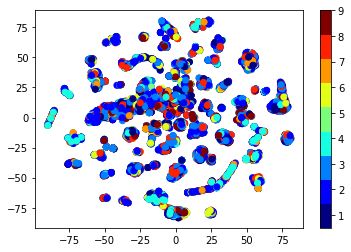

In [30]:
# check out the course content for more explantion on tsne algorithm
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/t-distributed-stochastic-neighbourhood-embeddingt-sne-part-1/

#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_asm.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

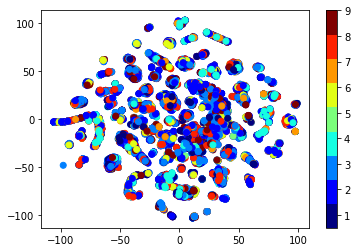

In [38]:
# by univariate analysis on the .asm file features we are getting very negligible information from 
# 'rtn', '.BSS:' '.CODE' features, so heare we are trying multivariate analysis after removing those features
# the plot looks very messy

xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_asm.drop(['ID','Class', 'rtn', '.BSS:', '.CODE','size'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

In [39]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [40]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [41]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
retn       False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
shl        False
ror        False
rol        False
jnb        False
jz         False
lea        False
movzx      False
.dll       False
std::      False
:dword     False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
size       False
dtype: bool


# Models on asm features

## K-NN

log_loss for k =  1 is 0.10127437612028622
log_loss for k =  3 is 0.09524354786219924
log_loss for k =  5 is 0.10436891825402558
log_loss for k =  7 is 0.11129332083197661
log_loss for k =  9 is 0.11942226244923324
log_loss for k =  11 is 0.127088325527274
log_loss for k =  13 is 0.13668709601540513
log_loss for k =  15 is 0.14508642813206452
log_loss for k =  17 is 0.1521274475709601
log_loss for k =  19 is 0.15899596955244505


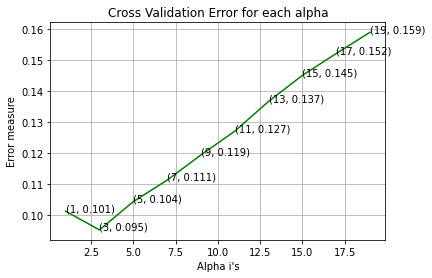

log loss for train data 0.04748842072884313
log loss for cv data 0.09524354786219924
log loss for test data 0.07079884069040913
Number of misclassified points  1.3339466421343145
-------------------------------------------------- Confusion matrix --------------------------------------------------


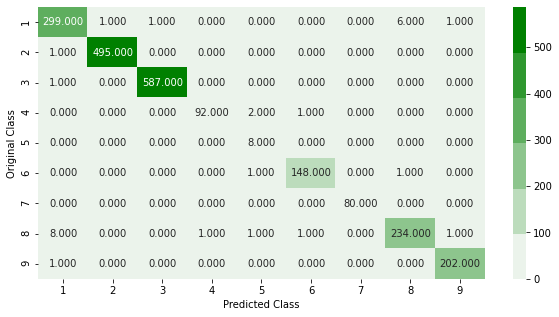

-------------------------------------------------- Precision matrix --------------------------------------------------


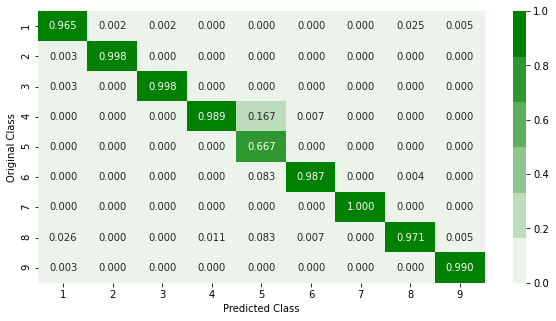

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


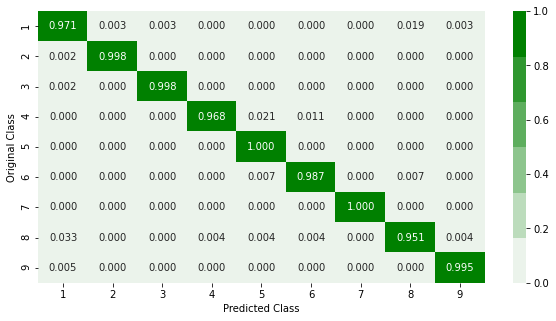

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [42]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

## Logistic Regression

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

## Random Forest

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

## XG Boost

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

## Xgboost Classifier with best hyperparameters

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

In [ ]:
print (random_cfl.best_params_)

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=200,subsample=0.5,learning_rate=0.15,colsample_bytree=0.5,max_depth=3)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

# Machine Learning models on features of both .asm and .bytes files

In [19]:
result_x = pd.merge(result,result_asm.drop(['Class'], axis=1),on='ID', how='left')
result_y = result_x['Class']
result_x = result_x.drop(['ID','rtn','.BSS:','.CODE','Class'], axis=1)
result_x.head()

,0,1,2,3,4,5,6,7,8,9,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,size_y
0,0.001942,0.000381,0.000078,0.000125,0.000174,0.000084,0.000093,0.000405,0.000464,0.000164,...,0.000191,0.000113,0.000060,0.000075,0.000089,0.0,0.007246,0.000000,0.004267,0.006865
1,0.003077,0.009624,0.000052,0.000039,0.000075,0.000039,0.000021,0.000126,0.000965,0.000188,...,0.003168,0.012508,0.003758,0.004902,0.001618,0.0,0.005435,0.000000,0.002298,0.144251
2,0.029941,0.216795,0.014241,0.013532,0.002550,0.001422,0.001569,0.006630,0.010644,0.002559,...,0.008663,0.015920,0.014912,0.011318,0.004573,0.0,0.007246,0.000917,0.009738,0.240151
3,0.003928,0.001221,0.000296,0.000304,0.000315,0.000307,0.000294,0.001463,0.001193,0.000575,...,0.002767,0.001638,0.002693,0.001271,0.003299,0.0,0.063406,0.000000,0.005909,0.036830
4,0.004889,0.011845,0.001862,0.001769,0.002059,0.001840,0.001801,0.009158,0.007278,0.003526,...,0.001889,0.001491,0.004783,0.001087,0.003325,0.0,0.021739,0.000000,0.004267,0.001075


## Train data extraction

In [52]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/4117/46665/train.7z?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1612764500&Signature=VRdHbbfupLn2Qgar11iS9qtLC9jA05OUuGDL8NDCZSj9gxpTEzwesVHUluq1N9qfRoJJtzB%2F8gWWXMM79lbl7McOc1xGSRX2jrw%2F1tVGPYyuY4PVmQH37aEvlQ8mFpsFLTuR6eQK%2BhRF0cmJrnwcGmh9VGW8RuZbRg0er7J6bpmPDrLhyeiTUiLxaHdt0oBjU%2BsxdNgi2kkJqzgrC0TX1ejGJ9XU1Jl8372Hl2xzJvfVLK7u1t%2FGCfnjlNzVWTarY4l411fBDTvBfQ%2BJ9Gj6xCcZtYpSP%2Fo6qpL64e8M7sWyhh%2BLWmyqN8zEcOVQDXym3ni49fZadCloXI4bhYS63w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.7z" -c -O 'train.7z'

--2021-02-06 08:27:38--  https://storage.googleapis.com/kagglesdsdata/competitions/4117/46665/train.7z?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1612764500&Signature=VRdHbbfupLn2Qgar11iS9qtLC9jA05OUuGDL8NDCZSj9gxpTEzwesVHUluq1N9qfRoJJtzB%2F8gWWXMM79lbl7McOc1xGSRX2jrw%2F1tVGPYyuY4PVmQH37aEvlQ8mFpsFLTuR6eQK%2BhRF0cmJrnwcGmh9VGW8RuZbRg0er7J6bpmPDrLhyeiTUiLxaHdt0oBjU%2BsxdNgi2kkJqzgrC0TX1ejGJ9XU1Jl8372Hl2xzJvfVLK7u1t%2FGCfnjlNzVWTarY4l411fBDTvBfQ%2BJ9Gj6xCcZtYpSP%2Fo6qpL64e8M7sWyhh%2BLWmyqN8zEcOVQDXym3ni49fZadCloXI4bhYS63w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.7z
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 74.125.137.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18810691091 (18G) [application/x-7z-compressed]
Saving to: ‘train.7z’

train.7z            100%[========

## bytefiles extraction

In [3]:
!7za e train.7z -o/asmFiles *.asm -r

zsh:1: no matches found: *.asm


## Byte Bi-gram features

In [20]:
result_x['ID'] = result.ID

In [2]:
byte_vocab = "00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

In [55]:
from itertools import combinations_with_replacement
comb = [' '.join(t) for t in combinations_with_replacement(byte_vocab.split(','), 2)]

In [70]:
len(comb)

33153

In [71]:
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=comb)
a = []
bytebigram_vect = scipy.sparse.csr_matrix((10868, 33153))
for i, file in tqdm(enumerate(os.listdir('byteFiles'))):
    f = open('byteFiles/' + file)
    bytebigram_vect[i,:]+= scipy.sparse.csr_matrix(vector.fit_transform([f.read().replace('\n', ' ').lower()]))
    f.close()

bytebigram_vect

1606it [18:32,  1.44it/s]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte

In [61]:
bytebigram_vect.todense()

matrix([[3.22660e+04, 8.59000e+02, 5.36000e+02, ..., 3.13600e+03,
         0.00000e+00, 0.00000e+00],
        [2.53050e+04, 9.66000e+02, 1.43000e+02, ..., 1.38000e+04,
         0.00000e+00, 0.00000e+00],
        [6.02200e+03, 3.40000e+01, 1.70000e+01, ..., 2.20000e+02,
         0.00000e+00, 0.00000e+00],
        ...,
        [1.35488e+05, 2.64600e+03, 2.24000e+02, ..., 2.35580e+04,
         0.00000e+00, 0.00000e+00],
        [2.96670e+04, 7.75000e+02, 5.35000e+02, ..., 3.57300e+03,
         0.00000e+00, 0.00000e+00],
        [7.03000e+03, 1.75600e+03, 1.47100e+03, ..., 2.86000e+02,
         0.00000e+00, 0.00000e+00]])

In [68]:
from scipy.sparse import csr_matrix
import numpy
import csv

csv_file = "bytebigram.csv"

df = pd.DataFrame(csr_matrix.todense(bytebigram_vect))
df.columns = comb
df.to_csv(csv_file, mode='a')


In [69]:
bigram_size_byte=pd.read_csv("bytebigram.csv")
bigram_size_byte.head()

,Unnamed: 0,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,fd fd,fd fe,fd ff,fd ??,fe fe,fe ff,fe ??,ff ff,ff ??,?? ??
0,0,32266.0,859.0,536.0,141.0,292.0,202.0,64.0,33.0,64.0,...,0.0,0.0,5.0,0.0,0.0,15.0,0.0,3136.0,0.0,0.0
1,1,25305.0,966.0,143.0,106.0,571.0,107.0,104.0,95.0,121.0,...,2.0,11.0,169.0,0.0,6166.0,310.0,0.0,13800.0,0.0,0.0
2,2,6022.0,34.0,17.0,71.0,23.0,55.0,20.0,41.0,26.0,...,19.0,8.0,20.0,0.0,18.0,36.0,0.0,220.0,0.0,0.0
3,3,17594.0,242.0,72.0,74.0,155.0,37.0,17.0,42.0,33.0,...,1.0,0.0,18.0,0.0,10.0,46.0,0.0,2114.0,0.0,0.0
4,4,13021.0,526.0,144.0,104.0,495.0,520.0,533.0,114.0,510.0,...,3.0,4.0,122.0,0.0,3.0,191.0,0.0,2153.0,0.0,0.0


In [ ]:
bigram_size_byte=pd.read_csv("bytebigram.csv")
bigram_size_byte.head()

In [8]:
scipy.sparse.save_npz('bytebigram.npz', bytebigram_vect)

In [33]:
from sklearn.preprocessing import normalize
byte_bigram_vect = normalize(scipy.sparse.load_npz('bytebigram.npz'), axis = 0)

In [34]:
byte_bigram_vect

<10868x66049 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

## ASM Bi-gram features

In [ ]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

In [ ]:
def asmopcodebigram():
    asmopcodebigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            asmopcodebigram.append(v + ' ' + opcodes[j])
    len(asmopcodebigram)

In [ ]:
asmopcodebigram

In [ ]:
vect = CountVectorizer(ngram_range=(2, 2), vocabulary = asmopcodebigram)
opcodebivect = scipy.sparse.csr_matrix((10868, len(asmopcodebigram)))
raw_opcode = open('opcode_file.txt').read().split('\n')

for indx in range(10868):
    opcodebivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [ ]:
opcodebivect

In [ ]:
scipy.sparse.save_npz('opcodebigram.npz', opcodebivect)

## Image Feature Extraction From ASM Files

In [ ]:
import array

def collect_img_asm():
    for asmfile in os.listdir("asmFiles"):
        filename = asmfile.split('.')[0]
        file = codecs.open("asmFiles/" + asmfile, 'rb')
        filelen = os.path.getsize("asmFiles/" + asmfile)
        width = int(filelen ** 0.5)
        rem = int(filelen / width)
        arr = array.array('B')
        arr.frombytes(file.read())
        file.close()
        reshaped = np.reshape(arr[:width * width], (width, width))
        reshaped = np.uint8(reshaped)
        scipy.misc.imsave('asm_image/' + filename + '.png',reshaped)

In [ ]:
collect_img_asm()

In [ ]:
from IPython.display import Image 
Image(filename='asm_image/deTXH9Zau7qmM0yfYsRS.png')

In [ ]:
import cv2
imagefeatures = np.zeros((10868, 800))

In [ ]:
for i, asmfile in enumerate(os.listdir("asmFiles")):
    img = cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    img_arr = img.flatten()[:800]
    imagefeatures[i, :] += img_arr

In [ ]:
imgfeatures_name = []
for i in range(200):
    img_features_name.append('pix' + str(i))
imgdf = pd.DataFrame(normalize(imagefeatures, axis = 0), columns = imgfeatures_name)

In [ ]:
imgdf['ID'] = result.ID
imgdf.head()

In [ ]:
joblib.dump(imgdf, 'img_df')